1. You will use the data from the attached spreadsheet. Sources of data are: St. Louis Fed for Cash (3 month Treasury Yield that I transformed in monthly returns assuming zero duration); MSCI for the stock indexes (MSCI USA, MSCI EAFE, MSCI EM); Yahoo Finance for the Vanguard Long Treasury Bond Fund (VUSTX) for government bonds; St. Louis Fed for bond indexes (ICE BofA US Corporate and US HY indexes)
2. For simplicity, we will use just historical data and no forward-looking capital market expectations. In the report, you will explain this and present a table of descriptive statistics (mean, std. dev., skewness and kurtosis) of the series; remember to annualize mean and standard deviation
3. A second table will show correlations 
4. In two charts next to each other you will compare the "layer cake" charts of the portfolio allocations without resampling and with resampling in the mean-variance case. Provide comments every time you have a table or a chart
5. Similarly for mean-CVaR you will show the charts
6. Select one allocation, say with a volatility of 7%, and show how the allocation differs in simple MVO, resampled MVO, simple CVaR and resampled CVaR (this means that you can compute the standard deviations for the CVaR portfolios as well, which is a simple matter as you know

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import datetime as dt
pd.options.display.min_rows=1000
pd.set_option('display.max_rows', 1000)
pd.set_option('display.min_rows', 1000)
pd.set_option('display.expand_frame_repr', True)

import pypfopt
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt.expected_returns import mean_historical_return
from pypfopt import black_litterman, risk_models
from pypfopt.expected_returns import mean_historical_return
from pypfopt import EfficientFrontier
pd.options.display.float_format = '{:,.4f}'.format
from IPython.core.display import display, HTML
display(HTML("<style> .container{width:96% !important;}</style>"))
pd.options.display.max_rows=150
pd.options.display.max_columns=150

In [2]:
### load data
df_stock_return_data= pd.read_excel("Index Monthly Time Series.xlsx")
df_stock_return_data=df_stock_return_data.set_index("Date")
df_stock_return_data.head(3)

,Cash,BondGov,BondIG,BondHY,EquityUS,EquityEAFE,EquityEM
Date,,,,,,,
1988-01-31,0.0047,0.0468,0.0383,0.0291,0.0396,0.0167,0.0942
1988-02-29,0.0047,0.0122,0.0168,0.0276,0.0387,0.0656,0.0024
1988-03-31,0.0048,-0.0232,-0.0114,-0.0019,-0.0365,0.0604,0.0999


In [3]:
def VaR_CVaR(data_series,
             significance_level):
    """Return VaR and CVaR and Tail Loss respectivley at the specifeid significance_level 
    1. VaR Based on Normal_Dist and sample mean and std 
    2. VaR Based on specified significance level quntile
    3. CVaR Based on avergae extreme values below VaR (VaR based on specified quantile)
    4. CVaR Based on Normal_Dist, sample mean and std, and VaR based on Quantile
    
    CVaR = (1/significance_level) * tail_loss
    """
    import scipy.stats
    import numpy as np
    mean=np.mean(data_series)
    std= np.std(data_series)
    #### Normal Dist VaR CVaR
    VaR_Normal_Dist=scipy.stats.norm.ppf(
        significance_level,
        loc = mean,
        scale = std)
    return_in_tail_based_on_VaR_Normal_Dist=data_series[data_series<VaR_Normal_Dist]
    
    tail_loss_Normal_dist = scipy.stats.norm.expect(lambda x: x,
                            loc = mean,
                            scale = std,
                            ub = VaR_Normal_Dist)
    CVaR_Normal = (1/significance_level) * tail_loss_Normal_dist
    
    
    #### T Dist Var CVaR
    t_dist_params = scipy.stats.t.fit(data_series)
    
    VaR_t_dist = scipy.stats.t.ppf(significance_level,*t_dist_params)
    tail_loss_t= scipy.stats.t.expect( lambda y: y, args = (t_dist_params[0],),
                                      loc = t_dist_params[1],
                                      scale = t_dist_params[2],
                                      ub = VaR_t_dist)
    
    CVaR_T = (1/significance_level) * tail_loss_t
    
    
    ### Data Driven VaR CVaR
    VaR_Quantile = np.quantile(data_series,significance_level)
    return_in_tail_based_on_VaR_Quantile=data_series[data_series<VaR_Quantile]
    CVaR_Quantile=np.mean(return_in_tail_based_on_VaR_Quantile)    
    
    
    #### VaR and CVaR GEV 
    genextreme_params= scipy.stats.genextreme.fit(-1*data_series)
    VaR_GEV = (scipy.stats.genextreme.ppf((1-significance_level), *genextreme_params))
    
    tail_loss_GEV = scipy.stats.genextreme.expect(lambda x: x, 
           args=(genextreme_params[0],),
                                                   loc = genextreme_params[1], 
                                              scale = genextreme_params[2],
                                              lb = VaR_GEV)
    CVaR_GEV = ((1/(significance_level)) * tail_loss_GEV)
    
    
    return ({"VaR_Normal_Dist":VaR_Normal_Dist,
             "VaR_GEV":VaR_GEV*-1,
             "VaR_t_dist":VaR_t_dist,
             "VaR_Quantile":VaR_Quantile,
             
            "CVaR_Normal":CVaR_Normal,
            "CVaR_GEV":CVaR_GEV*-1,
             "CVaR_T":CVaR_T,
             "CVaR_Quantile":CVaR_Quantile
            })

In [4]:
def VaR_CVaR_Quantile(data_series,
                      significance_level):
    """Returnn Value at Risk (VaR) and Conditional Value at Risk (CVaR) at significance_level"""
    import scipy.stats
    import numpy as np
    mean=np.mean(data_series)
    std= np.std(data_series)
    ### Data Driven VaR CVaR
    VaR_Quantile = np.quantile(data_series,significance_level)
    return_in_tail_based_on_VaR_Quantile=data_series[data_series<VaR_Quantile]
    CVaR_Quantile=(np.mean(return_in_tail_based_on_VaR_Quantile))
    return(VaR_Quantile,CVaR_Quantile)

In [5]:
def portfolio_return_series_computer(df_return_data,
                                     df_weights,
                                     list_of_assets_columns):
    """This function is to create return series of a portfolo taking weights of assest and return of assest"""
    df_portfolios_return=df_return_data[list_of_assets_columns].dot(
        df_weights[list_of_assets_columns].T)
    #df_portfolios_return.reset_index(inplace=True)
    df_portfolios_return=pd.melt(df_portfolios_return,var_name="portfolio",value_name="return")
    return(df_portfolios_return)

In [6]:
def portfolio_stats_computer(portfolio_return_series,
                            frequency=252):
    """This Function is to computer Annualized Return and Volatility of a series given the series and its frequency
    VaR and CVaR are at 5%"""
    portfolio_return_series=pd.Series(portfolio_return_series)
    
    portfolio_annualized_compouded_return = (1 + portfolio_return_series).prod() ** (frequency / portfolio_return_series.count()) - 1
    portfolio_annualized_simple_return = portfolio_return_series.mean()*frequency
    portfolio_annualized_volatility= portfolio_return_series.std()*np.sqrt(frequency)
    portfolio_VaR_05, portfolio_CVaR_05 = VaR_CVaR_Quantile(portfolio_return_series,0.05)
    portfolio_sharp_ratio = portfolio_annualized_compouded_return/portfolio_annualized_volatility
    
    portfolio_kurtosis= scipy.stats.kurtosis(portfolio_return_series)+3
    portfolio_skewness= scipy.stats.skew(portfolio_return_series)
    
    dict_stats={"Annualized Simple Return":[portfolio_annualized_simple_return],
                "Annualized Compunded Return":[portfolio_annualized_compouded_return],
                "Annualized Volatility":[portfolio_annualized_volatility],
                "Sharp Ratio":[portfolio_sharp_ratio],
                "Kurtosis":[portfolio_kurtosis],
                "Skewness":[portfolio_skewness],
                "VaR 5":[portfolio_VaR_05],
                "CVaR 5":[portfolio_CVaR_05]}
    return pd.DataFrame(dict_stats)

In [7]:
def portfolio_performance_computer(df_return_data,
                                   df_weights,
                                   list_of_assets_columns,
                                   frequency=252):
    """This function utlize portfolio_return_series_computer and portfolio_stats_computer to compute 
    Annualized Simple Return and Annualized Volatility of portfolios. The inputs are:
    df_return_data: return of the assets and 
    df_weights:weights of assets in each portfolio.
    frequency: frequency of the return data"""
    df_portfolios_return_series = portfolio_return_series_computer(df_return_data,
                                                                   df_weights,
                                                                   list_of_assets_columns)
    
    df_portfolios_return_series_stats=df_portfolios_return_series.groupby(
        "portfolio")["return"].apply(lambda x: portfolio_stats_computer(x,frequency=frequency))
    list_of_stats=df_portfolios_return_series_stats.columns.to_list()
    df_portfolios_return_series_stats.reset_index(inplace=True)
    df_portfolios_return_series_stats=pd.concat([df_weights,
                                                 df_portfolios_return_series_stats],
                                                ignore_index=False,axis=1)
    df_portfolios_return_series_stats.sort_values(["Annualized Volatility"],inplace=True)
    df_portfolios_return_series_stats.reset_index(drop=True,inplace=True)
    return df_portfolios_return_series_stats.drop(["portfolio","level_1"],axis=1)

In [8]:
def efficient_portfolio_instance(df_return_data,
                                 frequency=252,
                                 covarirance_method="ledoit_wolf",
                                 compound_return=False,
                                 weight_bounds=(0,1)):
    """df_return_data: asset prices or return
    frequency: frequency of your data, by default is 252 (Daily Return)
    compound_return: comound the return or simple return. Set it True for Compounding and False for simple return
    risk_aversion: utility,
    covarirance_method: sample_cov,semicovariance, exp_cov, min_cov_determinant, ledoit_wolf,
    ledoit_wolf_constant_variance, ledoit_wolf_single_factor, ledoit_wolf_constant_correlation,oracle_approximating
    target_risk: amount of annualized volatility. If not specified, it optimzes for the lowest CVaR portfolio"""
    ### Get Annualized Mean and Covairance
    annualized_return = mean_historical_return(df_return_data,
                                               returns_data=True,
                                               frequency=frequency,
                                               compounding=compound_return)
    
    annualized_cov= pypfopt.risk_models.risk_matrix(df_return_data,
                                                    returns_data=True,
                                                    method=covarirance_method,
                                                    frequency=frequency)
    ef= EfficientFrontier(annualized_return,
                          annualized_cov,
                          weight_bounds=weight_bounds)
    return(ef)

In [9]:
def efficient_frontier_calculator(df_return_data,
                                  frequency=252,
                                  covarirance_method="ledoit_wolf",
                                  compound_return=False,
                                  portfolio_performance=False,
                                  weight_bounds=(0,1),
                                  volatility_point=1000):
    list_of_assets=df_return_data.columns.tolist()
    ef_for_min_vol = efficient_portfolio_instance(df_return_data,
                                                  frequency=frequency,
                                                  covarirance_method=covarirance_method,
                                                  compound_return=compound_return,
                                                  weight_bounds=weight_bounds)
    ef_for_min_vol.min_volatility()
    min_possible_annualized_volatility = ef_for_min_vol.portfolio_performance()[1] + 0.001
    max_possible_annualzied_volatility = (df_return_data.std()*np.sqrt(frequency)).max() + 0.001
    delta = (max_possible_annualzied_volatility - min_possible_annualized_volatility)
    ### Generate enough number of evenly spaced point of volatility
    range_of_annualzied_volatility=np.linspace(min_possible_annualized_volatility,
                                               max_possible_annualzied_volatility,
                                               num=int(delta*volatility_point))
    list_of_df_weights=[]
    for target_risk in range_of_annualzied_volatility:
        try:
            ef =efficient_portfolio_instance(df_return_data,
                                             frequency=frequency,
                                             covarirance_method=covarirance_method,
                                             compound_return=compound_return,
                                             weight_bounds=weight_bounds)
            ef.efficient_risk(target_risk)
            ### Get The Weights of asset in portfolio
            df_weights = pd.DataFrame([ef.weights],
                                      columns=list_of_assets)
            df_weights["target_risk"]=target_risk
            list_of_df_weights.append(df_weights)
        except:
            pass
    
    ### Concatinate all the Portfolios with target risk
    df_efficient_frontier=pd.concat(list_of_df_weights,
                                    ignore_index=True)
    
    ### There are replicated portfolios, get rid of them
    df_efficient_frontier=df_efficient_frontier.drop_duplicates(list_of_assets).reset_index(drop=True)
    ### Computer Portfolio Performance
    if portfolio_performance:
        df_efficient_frontier=portfolio_performance_computer(df_return_data,
                                                             df_efficient_frontier,
                                                             list_of_assets,
                                                             frequency=frequency)
    return(df_efficient_frontier)

In [10]:
def data_shaker(df_return_data,
                shake_magnitude=.05,
                multivariate_normal=True):
    """Add some random white noise with mean zeror some magnitude of the covariance matrix
    multivariate_normal: Add some random white noise with mean zeror magnitude of the standard deviation of the underlying asset. """
    if multivariate_normal:
        random_noise= np.random.multivariate_normal(df_return_data.mean()*0,
                                                    df_return_data.cov(),
                                                    len(df_return_data))
        df_return_data_with_random_noise= df_return_data + (random_noise*shake_magnitude)
    
    if multivariate_normal == False:
        number_of_observation=df_return_data.shape[0]
        number_of_asset=df_return_data.shape[1]
        data_std=df_return_data.std()
        random_noise= np.random.normal(loc=0,
                                      scale=data_std,
                                      size=(number_of_observation,number_of_asset))
        df_return_data_with_random_noise= df_return_data + (random_noise*shake_magnitude)
    return(df_return_data_with_random_noise)

In [11]:
def multivariate_normal_return_simulator(df_return_data,
                                         number_of_return_series_to_be_simulated):
    """multivariate_normal Return simulator"""
    list_of_assets = df_return_data.columns.to_list()
    ### Simulate the returns
    simulated_returns = np.random.multivariate_normal(df_return_data.mean(),
                                                      df_return_data.cov(),
                                                      number_of_return_series_to_be_simulated)
    ### Put those simulated returns into DataFrame
    df_simulated_returns = pd.DataFrame(simulated_returns,
                                        columns=list_of_assets)
    return(df_simulated_returns)

In [12]:
def efficient_frontier_simulator_multivariate_normal(df_return_data,
                                                    number_of_simulation=10,
                                                    frequency=252,
                                                    compound_return=False,
                                                    covarirance_method="ledoit_wolf",
                                                    weight_bounds=(0, 1),
                                                    volatility_point=1000):
    """ Simulate Multi variate Normal Distribution return from actual data. Then construct number_of_simulation efficinet 
    frontier.
    df_return_data: returns of assets
    number_of_simulation: number of simulation to run
    frequency: frequency of data, daily=252, monthly =12 etc.
    compound_return: compouding return or simple return"""
    list_of_assets=df_return_data.columns.tolist()
    ### Consurtct Efficient Frontiter with simulated Return and Covriance matrix
    list_of_simulated_portfolios=[]
    for i in range(number_of_simulation):
        df_data_return_simulated= multivariate_normal_return_simulator(df_return_data,
                                                                       len(df_return_data))
        ### Don't calcualte portfolio perfomrnace the with efficient_frontier_calculator
        ### Because the returns are simulated return, not actual
        df_weights = efficient_frontier_calculator(df_data_return_simulated,
                                                   frequency=frequency,
                                                   compound_return=compound_return,
                                                   covarirance_method=covarirance_method,
                                                   portfolio_performance=False,
                                                   weight_bounds=weight_bounds,
                                                   volatility_point=volatility_point)
        df_weights["Simulation"]=i
        list_of_simulated_portfolios.append(df_weights)
    ### Concatinate all the simulated returns into 1 dataframe
    df_simulated_efficient_frontier = pd.concat(list_of_simulated_portfolios,
                                                ignore_index=True)
    
    ### Compute the return and volatility of each portfolio based on actual return data
    df_simulated_efficient_frontier= portfolio_performance_computer(df_return_data,
                                                                    df_simulated_efficient_frontier,
                                                                    list_of_assets,
                                                                    frequency)
    
    return(df_simulated_efficient_frontier)

In [13]:
def efficient_frontier_simulator_shaking_returns(df_return_data,
                                                 list_of_shaking_magnitude=[10,15,20,25,30,35,40],
                                                 frequency=252,
                                                 compound_return=False,
                                                 covarirance_method="ledoit_wolf",
                                                 multivariate_normal=True,
                                                 volatility_point=1000,
                                                 weight_bounds=(0,1)):
    list_of_assets=df_return_data.columns.tolist()
    """ Inject white noise with mean 0 and std*%shaking_magnitude into the resturn to consturct 
    multiple efficient frontier
    df_return_data: Retuns of asstes
    list_of_shaking_magnitude: list of magnitude to shake the returns, based on percentage of standard deviation of the
    underlying asset  20% 10% etc.
    frequency: data frequency. Default 252 daily. 12 monthly etc.
    """
    list_of_simulated_portfolios=[]
    for shake in list_of_shaking_magnitude:
        shake=shake/100
        df_data_return_simulated = data_shaker(df_return_data,
                                               shake_magnitude=shake,
                                               multivariate_normal=multivariate_normal)
        ### Don't calcualte portfolio perfomrnace the with efficient_frontier_calculator
        ### Because the returns are simulated return, not actual
        df_weights = efficient_frontier_calculator(df_data_return_simulated,
                                                   frequency=frequency,
                                                   compound_return=compound_return,
                                                   covarirance_method=covarirance_method,
                                                   portfolio_performance=False,
                                                   weight_bounds=weight_bounds,
                                                   volatility_point=volatility_point)
        df_weights["shake"] = shake
        list_of_simulated_portfolios.append(df_weights)
    
    ### Concatinate all the portfolios
    df_simulated_efficient_frontier=pd.concat(list_of_simulated_portfolios,
                                              ignore_index=True)
    ### Compute Portfolios performances
    df_simulated_efficient_frontier=portfolio_performance_computer(df_return_data,
                                                                   df_simulated_efficient_frontier,
                                                                   list_of_assets,
                                                                   frequency)
    return (df_simulated_efficient_frontier)

In [14]:
def data_bin_qty_comuter(values,
                         spacing):
    import pandas as pd
    import numpy as np
    """Determine how many bins are needed for eqaully spaced bins with the spacing specified"""
    values_series=pd.Series(values)
    values_series_min=values_series.min()
    values_series_max=values_series.max()
    values_series_evenly_spaced=np.arange(values_series_min,
                                          values_series_max+spacing,
                                          spacing)
    number_of_bins_for_splititng_volatilies= len(values_series_evenly_spaced)
    return(number_of_bins_for_splititng_volatilies)

def portfolio_resampler(volatility_series,
                        volatility_spacing):
    volatility_series=pd.Series(volatility_series)
    number_of_bins = data_bin_qty_comuter(values = volatility_series,
                                          spacing =volatility_spacing)
    return (pd.cut(volatility_series,number_of_bins))

def efficient_frontier_resampler(df_efficient_frontiers,
                                 df_return_data,
                                 volatility_spacing=.005,
                                 frequency=252):
    list_of_assets = df_return_data.columns.tolist()
    df_weights_resampled = df_efficient_frontiers.copy()
    ### Resmaple the portfolios based on volatility bins
    df_weights_resampled["Volatility Bins"]= portfolio_resampler(df_weights_resampled["Annualized Volatility"],
                                                                 volatility_spacing)
    df_weights_resampled["Volatility Bins"]=df_weights_resampled["Volatility Bins"].astype(str)
    ### Get the Average weight of each asset in resampled portfolios from each bin
    df_weights_resampled = df_weights_resampled.groupby(["Volatility Bins"])[list_of_assets].mean().reset_index().dropna()
    ### Compute the performance of the resmapled portfolios
    df_weights_resampled=portfolio_performance_computer(df_return_data,
                                                        df_weights_resampled,
                                                        list_of_assets,
                                                        frequency)
    return(df_weights_resampled)

In [15]:
def efficient_portfolio_CVaR_calculator(df_return_data,
                                        CVaR_Significance=0.05,
                                        target_risk=None,
                                        frequency=252,
                                        compound_return=False,
                                        weight_bounds=(0,1),
                                        covarirance_method="sample_cov",
                                        solver="SLSQP",
                                        portfolio_performance=False):
    """covarirance_method: sample_cov,semicovariance, exp_cov, min_cov_determinant, ledoit_wolf,
    ledoit_wolf_constant_variance, ledoit_wolf_single_factor, ledoit_wolf_constant_correlation,oracle_approximating
    target_risk: amount of annualized volatility. If not specified, it optimzes for the lowest CVaR portfolio"""
    list_of_assets= df_return_data.columns.tolist()
    ### CVAR Faunction to be minimiazedd
    def CVaR_Quantile_Method(w,
                             return_series,
                             significance_level):
        import scipy.stats
        import numpy as np
        data_series = return_series.dot(w)
        mean = np.mean(data_series)
        std = np.std(data_series)
        ### Data Driven VaR CVaR
        VaR_Quantile = np.quantile(data_series,significance_level)
        return_in_tail_based_on_VaR_Quantile=data_series[data_series<VaR_Quantile]
        CVaR_Quantile=(np.mean(return_in_tail_based_on_VaR_Quantile))*(-1)
        return(CVaR_Quantile)
    
    ef = efficient_portfolio_instance(df_return_data,
                                      frequency=frequency,
                                      covarirance_method=covarirance_method,
                                      compound_return=compound_return,
                                      weight_bounds=weight_bounds)
    
    ### Minimize the CVaR function subject to no constrian
    if target_risk==None:
        ef.nonconvex_objective(CVaR_Quantile_Method,
                               solver=solver,
                               weights_sum_to_one=True,
                               objective_args=(df_return_data.values,
                                               CVaR_Significance))
    else:
        # Portfolio vol less than target vol
        risk_constr = {"type": "eq",
                       "fun": lambda w: target_risk ** 2 - np.dot(w.T, np.dot(ef.cov_matrix, w))}
        constraints = [risk_constr]
        ### Minimize the CVaR function with subject to Volatility constrian
        ef.nonconvex_objective(CVaR_Quantile_Method,
                               solver=solver,
                               constraints=constraints,
                               weights_sum_to_one=True,
                               objective_args=(df_return_data.values,
                                               CVaR_Significance))    
    ### Get The Weights of asset in portfolio
    #### Store the outputs into the dataframe 
    df_weights =  pd.DataFrame([ef.weights],
                                      columns=list_of_assets)
    df_weights["CVaR Significance"]=CVaR_Significance
    
    ### Computer Portfolio Performance
    if portfolio_performance:
        df_weights=portfolio_performance_computer(df_return_data,
                                                  df_weights,
                                                  list_of_assets,
                                                  frequency=frequency)
    return(df_weights)

In [16]:
def efficient_frontier_CVaR_calculator(df_return_data,
                                       CVaR_Significance=0.05,
                                       frequency=252,
                                       compound_return=False,
                                       weight_bounds=(0,1),
                                       covarirance_method="sample_cov",
                                       solver="SLSQP",
                                       portfolio_performance=False,
                                       volatility_point=1000):
    """covarirance_method: sample_cov,semicovariance, exp_cov, min_cov_determinant, ledoit_wolf,
    ledoit_wolf_constant_variance, ledoit_wolf_single_factor, ledoit_wolf_constant_correlation,oracle_approximating
    volatility_points: Number of evenly spaced volatility portfolio to be created if you need more precise volatility CVaR portfolio,
    increase it. Will be computationaly more expensive """
    list_of_assets= df_return_data.columns.tolist()
    ### CVAR Faunction to be minimiazedd
    def CVaR_Quantile_Method(w,
                             return_series,
                             significance_level):
        import scipy.stats
        import numpy as np
        data_series = return_series.dot(w)
        mean = np.mean(data_series)
        std = np.std(data_series)
        ### Data Driven VaR CVaR
        VaR_Quantile = np.quantile(data_series,significance_level)
        return_in_tail_based_on_VaR_Quantile=data_series[data_series<VaR_Quantile]
        CVaR_Quantile=(np.mean(return_in_tail_based_on_VaR_Quantile))*(-1)
        return(CVaR_Quantile)

    
    ef = efficient_portfolio_instance(df_return_data,
                                      frequency=frequency,
                                      covarirance_method=covarirance_method,
                                      compound_return=compound_return,
                                      weight_bounds=weight_bounds)
    
    ### Compute Min Volatility Portfolio
    ef.min_volatility()
    min_possible_annualized_volatility = ef.portfolio_performance()[1] + 0.001
    max_possible_annualzied_volatility = (df_return_data.std()*np.sqrt(frequency)).max() +  0.001
    delta = (max_possible_annualzied_volatility - min_possible_annualized_volatility)
    
    
    ### Generate enough number of evenly spaced point of volatility
    range_of_annualzied_volatility=np.linspace(min_possible_annualized_volatility,
                                               max_possible_annualzied_volatility,
                                               num=int(delta*volatility_point))
    
    ef = efficient_portfolio_instance(df_return_data,
                                      frequency=frequency,
                                      covarirance_method=covarirance_method,
                                      compound_return=compound_return,
                                      weight_bounds=weight_bounds)
    
    #### Portfolio vol less than target vol
    risk_constr = {"type": "eq",
                   "fun": lambda w: target_risk ** 2 - np.dot(w.T, np.dot(ef.cov_matrix, w))}
    constraints = [risk_constr]
    list_of_df_weights=[]
    ### Minimize the CVaR function with subject to Volatility constrian
    for target_risk in range_of_annualzied_volatility:
        try:
            ef.nonconvex_objective(CVaR_Quantile_Method,
                                   solver=solver,
                                   weights_sum_to_one=True,
                                   constraints=constraints,
                                   objective_args=(df_return_data.values,
                                                   CVaR_Significance))
            ### Get The Weights of asset in portfolio
            df_weights =  pd.DataFrame([ef.weights],
                                      columns=list_of_assets)
            #### Store the outputs into the dataframe 
            df_weights["CVaR Significance"]=CVaR_Significance
            list_of_df_weights.append(df_weights)
        except:
            pass
        
    ### Concatinate all the CVaR Portfolios
    df_efficient_frontier=pd.concat(list_of_df_weights,
                                    ignore_index=True)
  
    ### Computer Portfolio Performance
    if portfolio_performance:
        df_efficient_frontier=portfolio_performance_computer(df_return_data,
                                                             df_efficient_frontier,
                                                             list_of_assets,
                                                             frequency=frequency)
    return(df_efficient_frontier)

In [17]:
def efficient_frontier_CVaR_simulator_shaking_returns(df_return_data,
                                                     list_of_shaking_magnitude=[30,35,40,45,50],
                                                      multivariate_normal=True,
                                                      CVaR_Significance=0.05,
                                                     frequency=252,
                                                     compound_return=False,
                                                     weight_bounds=(0,1),
                                                     covarirance_method="sample_cov",
                                                     solver="SLSQP",
                                                     volatility_point=1000):
    list_of_assets= df_return_data.columns.tolist()
    list_of_simulated_portfolios=[]
    #### Shake the retruns with some percentage of their standadrd deviation- Adding white noise with mean zero.
    for shake in list_of_shaking_magnitude:
        shake=shake/100
        df_return_data_shaked = data_shaker(df_return_data=df_return_data,
                                            shake_magnitude=shake,
                                            multivariate_normal=multivariate_normal)
        
        df_weights= efficient_frontier_CVaR_calculator(df_return_data=df_return_data_shaked,
                                                      CVaR_Significance=CVaR_Significance,
                                                      frequency=frequency,
                                                      compound_return=compound_return,
                                                      weight_bounds=weight_bounds,
                                                      covarirance_method=covarirance_method,
                                                      solver=solver,
                                                      portfolio_performance=False,
                                                      volatility_point=volatility_point)
        df_weights["shake"]=shake
        list_of_simulated_portfolios.append(df_weights)
    ### Concatinate all the portfolios
    df_simulated_efficient_frontier = pd.concat(list_of_simulated_portfolios,
                                                ignore_index=True)
    
    ### Compute Portfolios performances
    df_simulated_efficient_frontier = portfolio_performance_computer(df_return_data,
                                                         df_simulated_efficient_frontier,
                                                         list_of_assets,
                                                         frequency)
    return (df_simulated_efficient_frontier)

### Descriptive Statistics

In [18]:
# pd.melt(df_stock_return_data).groupby("variable")["value"].apply(lambda x: portfolio_stats_computer(x,frequency=12)).to_excel(
#     "Asset Ret Summary.xlsx")

In [19]:
pd.melt(df_stock_return_data).groupby("variable")["value"].apply(lambda x: portfolio_stats_computer(x,frequency=12))

,,Annualized Simple Return,Annualized Compunded Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5
variable,,,,,,,,,
BondGov,0,0.0855,0.0834,0.1023,0.8152,4.3135,0.3443,-0.0370,-0.0535
BondHY,0,0.0819,0.0814,0.0824,0.9879,13.3350,-1.3065,-0.0271,-0.0553
BondIG,0,0.0709,0.0718,0.0528,1.3599,8.1784,-0.9249,-0.0148,-0.0301
Cash,0,0.0295,0.0299,0.0071,4.2265,1.9701,0.3589,0.0000,0.0000
EquityEAFE,0,0.0415,0.0277,0.1671,0.1659,4.0644,-0.4556,-0.0814,-0.1131
EquityEM,0,0.0987,0.0754,0.2242,0.3364,4.7768,-0.5808,-0.1026,-0.1469
EquityUS,0,0.0919,0.0844,0.1451,0.5812,4.2515,-0.5712,-0.0689,-0.0946


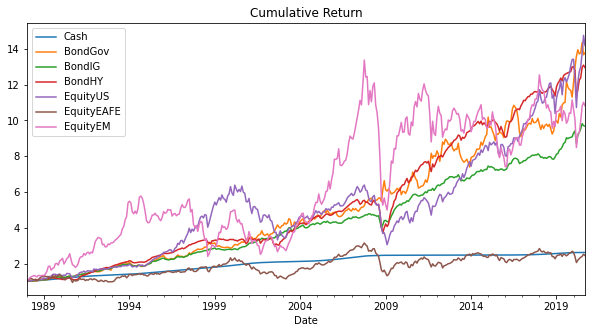

In [20]:
#### Cumulative Return
(df_stock_return_data+1).cumprod().plot(figsize=(10,5));
plt.title("Cumulative Return")
plt.show()

In [21]:
df_stock_return_data.corr().style.background_gradient(cmap='coolwarm')

,Cash,BondGov,BondIG,BondHY,EquityUS,EquityEAFE,EquityEM
Cash,1.000000,0.028888,0.062802,-0.020929,0.033231,0.005879,0.036370
BondGov,0.028888,1.000000,0.629989,-0.033416,-0.121615,-0.145430,-0.163084
BondIG,0.062802,0.629989,1.000000,0.563176,0.332808,0.300195,0.262047
BondHY,-0.020929,-0.033416,0.563176,1.000000,0.626200,0.579939,0.591960
EquityUS,0.033231,-0.121615,0.332808,0.626200,1.000000,0.740974,0.671808
EquityEAFE,0.005879,-0.145430,0.300195,0.579939,0.740974,1.000000,0.711434
EquityEM,0.036370,-0.163084,0.262047,0.591960,0.671808,0.711434,1.000000


### Construct Non-Resmapled Efficient Frontier

In [22]:
list_of_all_assets= df_stock_return_data.columns.to_list()

In [28]:
%%time
df_weights_MVO=efficient_frontier_calculator(df_stock_return_data,
                                  frequency=12,
                                  covarirance_method="sample_cov",
                                  compound_return=False,
                                  portfolio_performance=True,
                                  weight_bounds=(0,1),
                                  volatility_point=1200)

C:\Users\fbaharkoush\Anaconda3\envs\tensorflow_env\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Wall time: 5.36 s


In [29]:
df_weights_MVO.head(3)

,Cash,BondGov,BondIG,BondHY,EquityUS,EquityEAFE,EquityEM,target_risk,Annualized Simple Return,Annualized Compunded Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5
0,0.9244,0.0247,0.0101,0.0399,0.0008,0.0000,0.0000,0.0080,0.0334,0.0339,0.0080,4.2300,3.6249,-0.1742,-0.0008,-0.0020
1,0.8989,0.0325,0.0168,0.0494,0.0025,0.0000,0.0000,0.0089,0.0347,0.0353,0.0089,3.9812,4.6545,-0.3983,-0.0011,-0.0027
2,0.8773,0.0390,0.0226,0.0573,0.0040,0.0000,0.0000,0.0097,0.0358,0.0364,0.0097,3.7541,5.4339,-0.5480,-0.0014,-0.0034


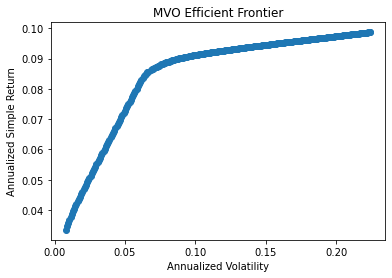

In [30]:
### Plot Efficient Frontier
plt.scatter(df_weights_MVO["Annualized Volatility"],
            df_weights_MVO["Annualized Simple Return"])
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Simple Return")
plt.title("MVO Efficient Frontier")
plt.show()

In [31]:
df_weights_MVO.sort_values("Sharp Ratio",ascending=False).head()

,Cash,BondGov,BondIG,BondHY,EquityUS,EquityEAFE,EquityEM,target_risk,Annualized Simple Return,Annualized Compunded Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5
0,0.9244,0.0247,0.0101,0.0399,0.0008,0.0000,0.0000,0.0080,0.0334,0.0339,0.0080,4.2300,3.6249,-0.1742,-0.0008,-0.0020
1,0.8989,0.0325,0.0168,0.0494,0.0025,0.0000,0.0000,0.0089,0.0347,0.0353,0.0089,3.9812,4.6545,-0.3983,-0.0011,-0.0027
2,0.8773,0.0390,0.0226,0.0573,0.0040,0.0000,0.0000,0.0097,0.0358,0.0364,0.0097,3.7541,5.4339,-0.5480,-0.0014,-0.0034
3,0.8577,0.0449,0.0278,0.0644,0.0053,0.0000,0.0000,0.0105,0.0369,0.0374,0.0105,3.5530,6.0199,-0.6508,-0.0016,-0.0040
4,0.8393,0.0504,0.0326,0.0712,0.0065,0.0000,0.0000,0.0114,0.0378,0.0384,0.0114,3.3760,6.4622,-0.7227,-0.0019,-0.0046


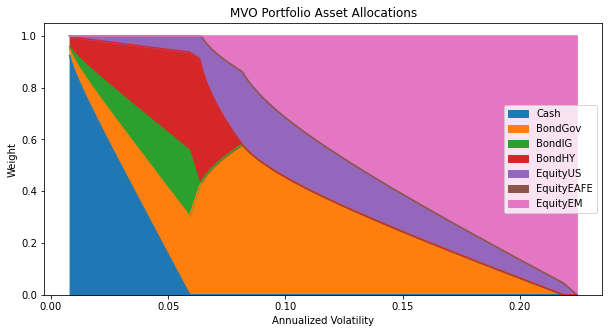

In [32]:
### Plot Asset Allocation
df_weights_MVO.set_index("Annualized Volatility")[list_of_all_assets].plot.area(figsize=(10,5))
plt.legend()
plt.xlabel("Annualized Volatility")
plt.ylabel("Weight")
plt.title("MVO Portfolio Asset Allocations")
plt.show()

### Construct Resmapled Efficient Frontier (multi Variate Normal)
Consurtct Efficient Frontiter with simulated Return and Covriance matrix for 100 times and then take the average weights of portfolios in each bucket of volatility.


https://www.newfrontieradvisors.com/media/1138/estimation-error-and-portfolio-optimization-12-05.pdf

In [33]:
%%time
#### Simulate N number of efficient Frontier via Multivarite Normal Distribution
df_weights_Multi_Normal_MVO_simulated = efficient_frontier_simulator_multivariate_normal(df_stock_return_data,
                                                                                        number_of_simulation=15,
                                                                                        frequency=12,
                                                                                        compound_return=False,
                                                                                        covarirance_method="sample_cov",
                                                                                        weight_bounds=(0, 1),
                                                                                        volatility_point=1200)

C:\Users\fbaharkoush\Anaconda3\envs\tensorflow_env\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Wall time: 1min 20s


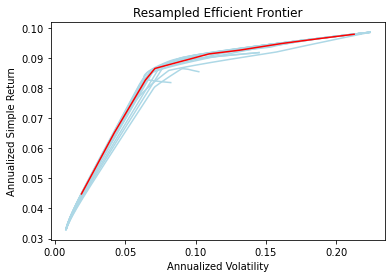

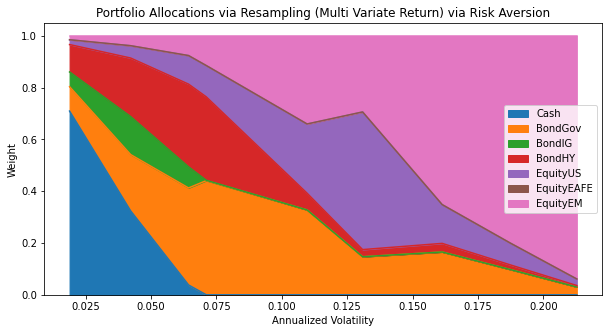

In [36]:
### resample the efficient frontier from N efficient frontier computed above
df_weights_Multi_Normal_RMVO= efficient_frontier_resampler(df_weights_Multi_Normal_MVO_simulated,
                                                           df_stock_return_data,
                                                           volatility_spacing=0.03,
                                                           frequency=12)

### Plot Efficient Frontier
df_weights_Multi_Normal_MVO_simulated.groupby("Simulation").apply(lambda x: plt.plot(x["Annualized Volatility"],
                                                                                     x["Annualized Simple Return"],
                                                                                    color="lightblue"))
plt.plot(df_weights_Multi_Normal_RMVO["Annualized Volatility"],
         df_weights_Multi_Normal_RMVO["Annualized Simple Return"],
        color="red")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Simple Return")
plt.title("Resampled Efficient Frontier")
plt.show()

### Plot Asset Allocation
df_weights_Multi_Normal_RMVO.set_index(["Annualized Volatility"])[list_of_all_assets].plot.area(figsize=(10,5))
plt.xlabel("Annualized Volatility")
plt.ylabel("Weight")
plt.title("Portfolio Allocations via Resampling (Multi Variate Return) via Risk Aversion")
plt.show()

### Construct Resmapled Efficient Frontier (Shaking)
Consurtct Efficient Frontiter with shaking Return and Covriance matrix. 
Then take the average weights of portfolios in volatility buckets 

In [39]:
%%time
df_weights_shaked_MVO_simulated_MN1 = efficient_frontier_simulator_shaking_returns(df_stock_return_data,
                                                                               list_of_shaking_magnitude=np.arange(25,40,.5),
                                                                               multivariate_normal=True,
                                                                               frequency=12,
                                                                               compound_return=False,
                                                                               covarirance_method="sample_cov",
                                                                               volatility_point=1200,
                                                                               weight_bounds=(0,1))

C:\Users\fbaharkoush\Anaconda3\envs\tensorflow_env\lib\site-packages\cvxpy\problems\problem.py:1055: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


Wall time: 2min 42s


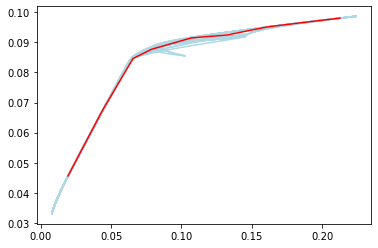

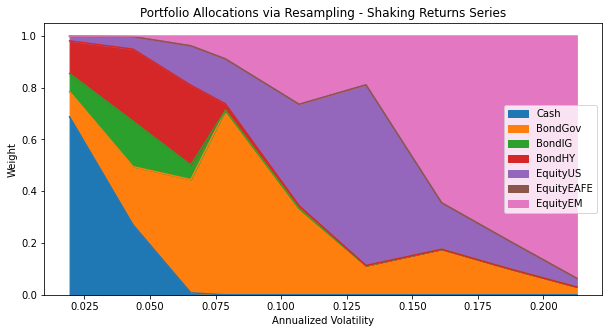

In [41]:
df_weights_shaked_MVO_simulated_MN1_resampled=efficient_frontier_resampler(df_weights_shaked_MVO_simulated_MN1,
                                                                           df_stock_return_data,
                                                                           volatility_spacing=0.03,
                                                                           frequency=12)

df_weights_shaked_MVO_simulated_MN1.groupby(['shake']).apply(lambda x: plt.plot(x["Annualized Volatility"],
                                                                                x["Annualized Simple Return"],
                                                                                color="lightblue"))

plt.plot(df_weights_shaked_MVO_simulated_MN1_resampled["Annualized Volatility"],
         df_weights_shaked_MVO_simulated_MN1_resampled["Annualized Simple Return"],
         color='red')
plt.show()

### Plot Asset Allocation
df_weights_shaked_MVO_simulated_MN1_resampled.set_index("Annualized Volatility")[list_of_all_assets].plot.area(figsize=(10,5))
plt.xlabel("Annualized Volatility")
plt.ylabel("Weight")
plt.title("Portfolio Allocations via Resampling - Shaking Returns Series")
plt.show()

### CVaR

In [42]:
efficient_portfolio_CVaR_calculator(df_stock_return_data,
                                        CVaR_Significance=0.05,
                                        target_risk=None,
                                        frequency=12,
                                        compound_return=False,
                                        weight_bounds=(0,1),
                                        covarirance_method="sample_cov",
                                        solver="SLSQP",
                                        portfolio_performance=True)

,Cash,BondGov,BondIG,BondHY,EquityUS,EquityEAFE,EquityEM,CVaR Significance,Annualized Simple Return,Annualized Compunded Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5
0,0.9998,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0500,0.0295,0.0299,0.0071,4.2288,1.9703,0.3590,0.0000,0.0000


In [43]:
%%time
df_weights_cvar_MVO = efficient_frontier_CVaR_calculator(df_stock_return_data,
                                                         CVaR_Significance=0.05,
                                                         frequency=12,
                                                         compound_return=False,
                                                         weight_bounds=(0,1),
                                                         covarirance_method="sample_cov",
                                                         solver="SLSQP",
                                                         portfolio_performance=True,
                                                         volatility_point=2500)
df_weights_cvar_MVO = df_weights_cvar_MVO.sort_values("Annualized Volatility").reset_index(drop=True)

Wall time: 28.7 s


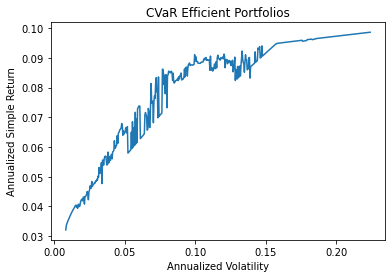

In [44]:
### Plot Efficient Frontier
plt.plot(df_weights_cvar_MVO["Annualized Volatility"],
         df_weights_cvar_MVO["Annualized Simple Return"])
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Simple Return")
plt.title("CVaR Efficient Portfolios")
plt.show()

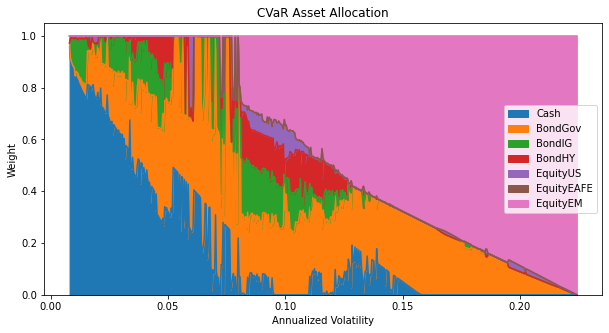

In [45]:
### Plot CVaR Asset Allocation
df_weights_cvar_MVO.set_index("Annualized Volatility")[list_of_all_assets].plot.area(figsize=(10,5))
plt.xlabel("Annualized Volatility")
plt.ylabel("Weight")
plt.title("CVaR Asset Allocation")
plt.show()

### Resmapled CVaR

In [46]:
%%time
df_weights_shaked_cvar_mvo = efficient_frontier_CVaR_simulator_shaking_returns(df_stock_return_data,
                                                     list_of_shaking_magnitude=np.arange(25,45,.25),
                                                      multivariate_normal=False,
                                                     CVaR_Significance=0.05,
                                                     frequency=12,
                                                     compound_return=False,
                                                     weight_bounds=(0,1),
                                                     covarirance_method="sample_cov",
                                                     solver="SLSQP",
                                                     volatility_point=1200)

Wall time: 19min 26s


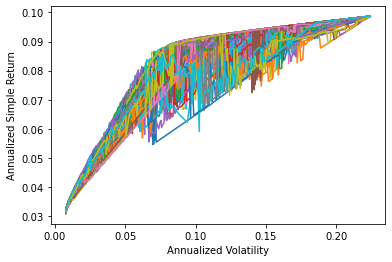

In [47]:
df_weights_shaked_cvar_mvo.groupby("shake").apply(lambda x: plt.plot(x["Annualized Volatility"],
                                                                     x["Annualized Simple Return"]))
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Simple Return")
plt.show()

In [48]:
### resample the efficient frontier from N efficient frontier computed above
df_weights_cvar_resampled_mvo= efficient_frontier_resampler(df_weights_shaked_cvar_mvo,
                                                            df_stock_return_data,
                                                            volatility_spacing=0.005,
                                                            frequency=12)

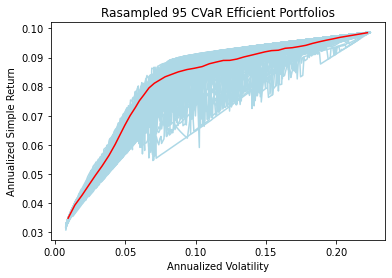

In [49]:
### Plot Efficient Frontier
df_weights_shaked_cvar_mvo.groupby("shake").apply(lambda x: plt.plot(x["Annualized Volatility"],
                                                                     x["Annualized Simple Return"],
                                                                    color="lightblue"))

plt.plot(df_weights_cvar_resampled_mvo["Annualized Volatility"],
            df_weights_cvar_resampled_mvo["Annualized Simple Return"],
        color="red")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Simple Return")
plt.title("Rasampled 95 CVaR Efficient Portfolios")
plt.show()

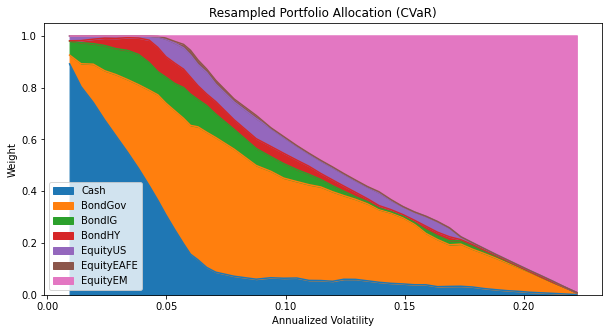

In [50]:
### Plot CVaR Asset Allocation
df_weights_cvar_resampled_mvo.set_index("Annualized Volatility")[df_stock_return_data.columns].plot.area(figsize=(10,5))
plt.xlabel("Annualized Volatility")
plt.ylabel("Weight")
plt.title("Resampled Portfolio Allocation (CVaR)")
plt.show()

### 7% Portfolios

In [51]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [ ]:
df_weights_Multi_Normal_RMVO

In [53]:
list_of_7percent_volatile_portfolio=[]
for df,port in zip([df_weights_cvar_MVO,
                    df_weights_cvar_resampled_mvo,
                    df_weights_MVO,
                    df_weights_Multi_Normal_RMVO],
                   ["CVaR",
                    "CVaR Resampled",
                    "MVO",
                    "Resampled MVO"]):
    df=df[df["Annualized Volatility"]== find_nearest(df["Annualized Volatility"],.07)]
    df["Allocation Method"]=port
    list_of_7percent_volatile_portfolio.append(df)

C:\Users\fbaharkoush\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [54]:
print("7% Volitile Portfolio Asset Allocation")
pd.concat(list_of_7percent_volatile_portfolio).drop(['CVaR Significance',
                                                    'Volatility Bins',
                                                     'target_risk'],axis=1)

7% Volitile Portfolio Asset Allocation


,Cash,BondGov,BondIG,BondHY,EquityUS,EquityEAFE,EquityEM,Annualized Simple Return,Annualized Compunded Return,Annualized Volatility,Sharp Ratio,Kurtosis,Skewness,VaR 5,CVaR 5,Allocation Method
154,0.0838,0.5455,0.3708,0.0000,0.0000,0.0000,0.0000,0.0754,0.0755,0.0698,1.0810,3.8991,0.1388,-0.0263,-0.0366,CVaR
15,0.0874,0.5202,0.0905,0.0484,0.0673,0.0148,0.1714,0.0812,0.0816,0.0707,1.1534,4.7343,-0.4912,-0.0274,-0.0415,CVaR Resampled
73,0.0000,0.5016,0.0000,0.2457,0.1897,0.0000,0.0630,0.0867,0.0876,0.0701,1.2495,5.6930,-0.6086,-0.0284,-0.0411,MVO
3,0.0000,0.4411,0.0013,0.3224,0.1209,0.0000,0.1143,0.0866,0.0874,0.0711,1.2290,7.0024,-0.8027,-0.0280,-0.0430,Resampled MVO


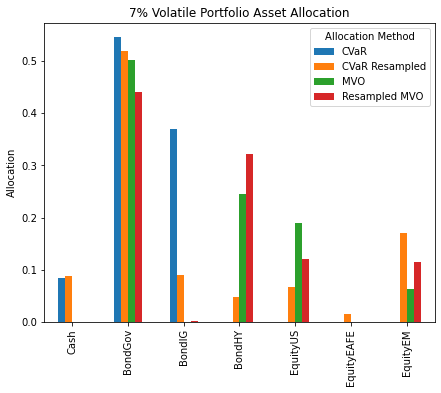

In [55]:
pd.concat(list_of_7percent_volatile_portfolio).set_index("Allocation Method")[list_of_all_assets].T.plot(figsize=(7,5.5),kind="bar");
plt.ylabel("Allocation")
plt.title("7% Volatile Portfolio Asset Allocation")
plt.show()